## Deriving the transfer function of virtual analog first order filters.

HTML output built with: jupyter nbconvert --to html one_pole_z_domain_tf.ipynb

Source:
http://www.willpirkle.com/Downloads/AN-4VirtualAnalogFilters.pdf

We will derive the algorithm from the block diagram found on page 5, but we will follow the style of [Andrew Simper's SVF paper](https://cytomic.com/files/dsp/SvfLinearTrapOptimised2.pdf).

Sympy can't (very easily) be bent to display transfer functions in terms of $z^{-1}, z^{-2}, ...$ which is the convention. Plain $z$ will be used here instead - keep in mind it actually means $z^{-1}$.

In [1]:
from sympy import *
init_printing()

z = symbols("z")

Start with the parameters.

```
g = Tan[π * cutoff / samplerate];
a1 = g / (1.0 + g);
```

The other coefficients defining the shape of the filter (`m0, m1`) will be ignored for now, as they are only used to "mix" the output.

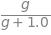

In [2]:
g = symbols("g")
a1 = g / (1.0 + g)

a1

Then the computation.

The variable `v0` represents the input signal - we will consider it to represent the z-transform of the input over time. `v1` and `v2` represent two other nodes in the block diagram.

The state variable `ic1eq` will be defined as unknown first, and then we will solve it using its equations.

The relevant lines of the algorithm are:

```
v1 = a1 * (v0 - ic1eq);
v2 = v1 + ic1eq;
```

Notice that `ic1eq` actually refers to the _previous_ value of these samples. This corresponds to multiplying by $z$ (contrary to convention!) in the z-domain.

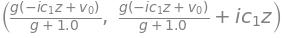

In [3]:
v0, ic1eq = symbols("v0 ic_1")

v1 = a1 * (v0 - ic1eq * z)
v2 = ic1eq * z + v1

(v1, v2)

The "new" value for `ic1eq` is computed as follows:

```
ic1eq = v2 + v1;
```

depending on the current values of `v1, v2`, and the previous value of `ic1eq`.

Consider this equation, and solve it:

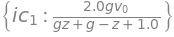

In [4]:
equation = [
    v2 + v1 - ic1eq, # = 0
]
solution = solve(equation, (ic1eq))

solution

We may now subsitute the solution into `v2` to obtain the transfer function

$$
\begin{aligned}
H_0(z) &= \frac {v_0(z)} {v_0(z)} = 1  \\
H_1(z) &= \frac {v_2(z)} {v_0(z)} \\
\end{aligned}
$$

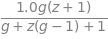

In [5]:
H0 = 1
H1 = v2.subs(solution) / v0
H1 = collect(simplify(H1), z)

(H1)

We can now assemble the complete transfer function, taking into account the mix coefficients `m0, m1`.

$$
H(z) = m_0 H_0(z) + m_1 H_1(z)
$$

1.0*g*m1*(z + 1)/(g + z*(g - 1) + 1) + m0


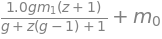

In [6]:
m0, m1 = symbols("m0 m1")

H = m0 * H0 + m1 * H1

print(H)
H

## Sanity check: High pass filter

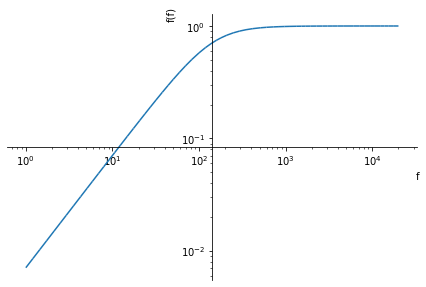

In [7]:
from sympy.functions import tan, exp

samplerate = 40_000
cutoff = sqrt(samplerate/2)

f = symbols("f")

H_hp_f = H.subs({
    g: tan(pi * cutoff / samplerate),
    m0: 1,
    m1: -1,
    z: exp(2*I*pi * f / samplerate)**-1,
})

plot(abs(H_hp_f), (f, 1, samplerate/2), xscale='log', yscale='log')